<a href="https://colab.research.google.com/github/alejandromunizsiques/alejandromunizsiques/blob/main/Online_Payments_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [1]:
import pandas as pd
import numpy as py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import plot_confusion_matrix



# Carga del dataset

In [2]:
Fraudes_df = pd.read_csv("/content/drive/MyDrive/Desafio NTTDATA LATAM/PS_20174392719_1491204439457_log.csv")

# Analisis Exploratorio

In [3]:
Fraudes_df 

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Target


0    6354407
1       8213
Name: isFraud, dtype: int64

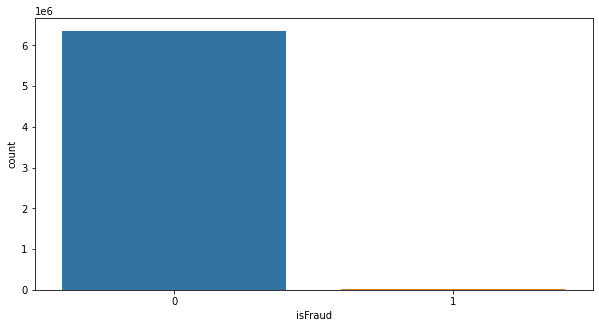

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(x = "isFraud" ,data = Fraudes_df)

Fraudes_df['isFraud'].value_counts()



Se determina un gran desequilidrio entre clases, por lo tanto se descarta el uso del Accuracy como metrica de evaluacion de los modelos a probar, ademas de estratificar los datos en funcion del target


Text(0.5, 1.0, 'Tipos de transaccion vs Fraudes')

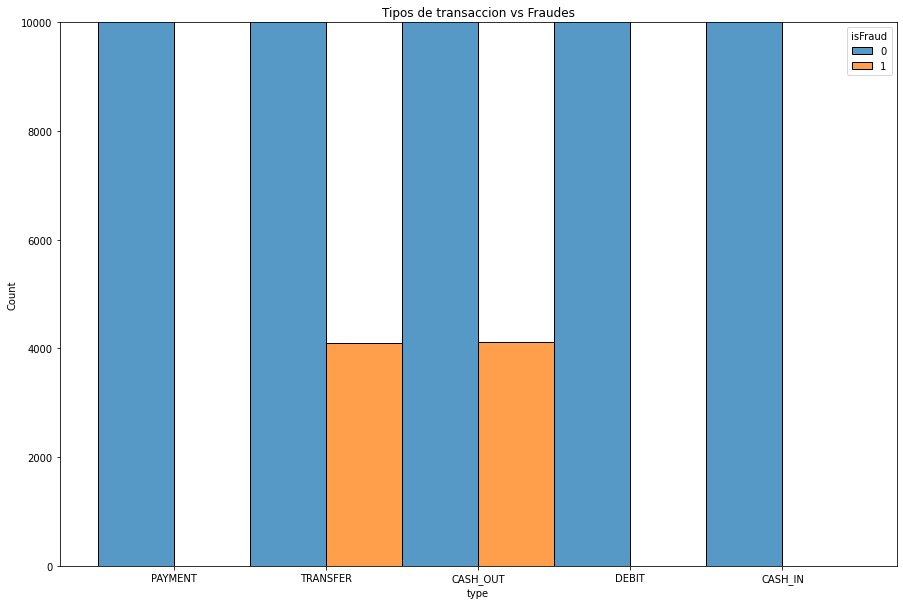

In [12]:


plt.figure(figsize=(15,10))
sns.histplot(x = "type" ,hue="isFraud",multiple="dodge", data = Fraudes_df, bins = 5)
plt.ylim(0, 10000)
plt.title("Tipos de transaccion vs Fraudes")



Se observa que la variable de tipo de operacion tiene relacion con respecto a si es fraude o no, por lo tanto es una variable que tendremos en cuenta al momento de generar el modelo

(0.0, 3000.0)

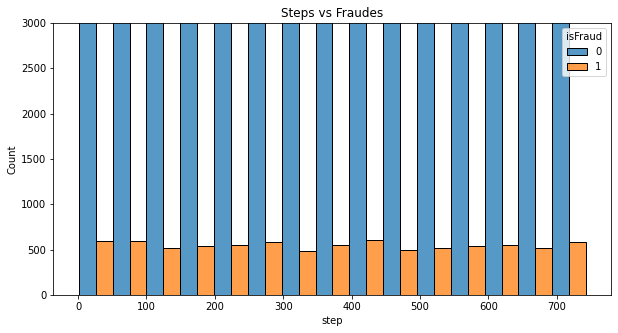

In [14]:

plt.figure(figsize=(10,5))
sns.histplot(x = "step" ,hue="isFraud",multiple="dodge", data = Fraudes_df, bins = 15)
plt.title("Steps vs Fraudes")
plt.ylim(0, 3000)

No se encuentra ninguna relacion evidente o tendencia marcada entre los fraudes y la cantidad de "Steps" (Medida de tiempo), por lo tanto esta variable sera descartada del modelo

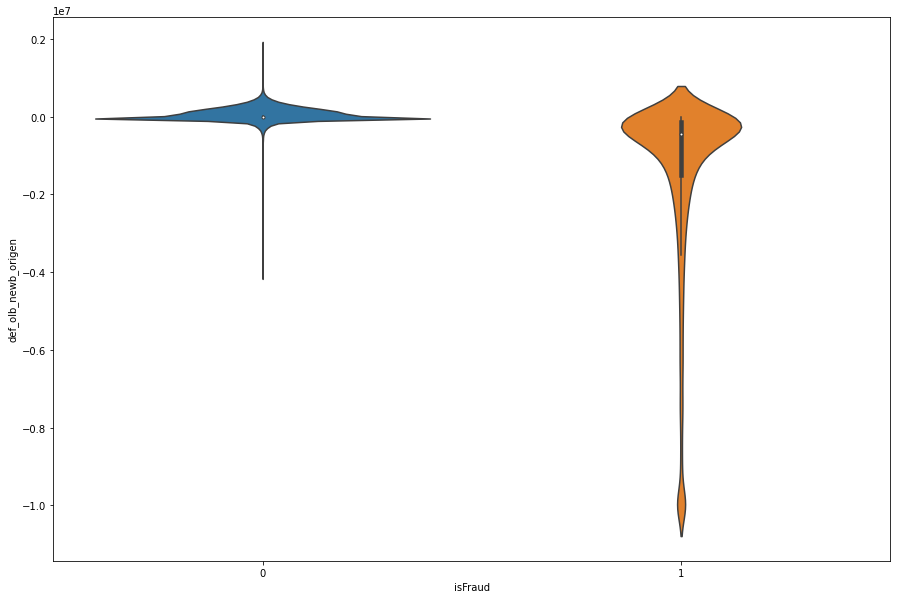

In [20]:
plt.figure(figsize=(15,10))
sns.violinplot(x=Fraudes_df.isFraud, y=Fraudes_df.def_olb_newb_origen)

Se pueden observar diferencias significativas en la distribucion de fraudes con respecto a la diferencia entre el balance inicial y final del emisor , por lo tanto se incluira en el modelo

# feature engineering


In [16]:
Fraudes_df['type'] = Fraudes_df['type'].map({"PAYMENT":1,"TRANSFER":2,"CASH_OUT":3,"DEBIT":4,"CASH_IN":5})

In [17]:
Fraudes_df["def_olb_newb_origen"] = Fraudes_df["newbalanceOrig"] - Fraudes_df["oldbalanceOrg"]

In [18]:
Fraudes_df["def_olb_newb_destino"]  = Fraudes_df["newbalanceDest"] - Fraudes_df["oldbalanceDest"]

In [19]:
Fraudes_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,def_olb_newb_origen,def_olb_newb_destino
0,1,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,-9839.64,0.00
1,1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,-1864.28,0.00
2,1,2,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,-181.00,0.00
3,1,3,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,-181.00,-21182.00
4,1,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,-11668.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,3,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,-339682.13,339682.13
6362616,743,2,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,-6311409.28,0.00
6362617,743,3,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,-6311409.28,6311409.27
6362618,743,2,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,-850002.52,0.00


# Sample


In [21]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

In [30]:
df_sample = Fraudes_df.sample(n=25000)
print(sorted(Counter(df_sample["isFraud"]).items()))

[(0, 24967), (1, 33)]


Se genera muetra del dataset original para entrenar los modelos, esta tendra 25000 registros

In [31]:
X = df_sample[["type","def_olb_newb_origen"]]
y = df_sample["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, test_size = 0.4, stratify= y,)

se genera una division de entrenamiento de un 60% y uno de prueba de un 40%

In [32]:
x_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 14980), (1, 14980)]


se genera un Oversamplig de los datos de entrenamiento, utilizando la tecnica "
ADASYN", de esta manera podremos superar el problema de desbalance generando nuevos datos con respecto a fraudes

# Generacion del modelo

## RandomForestClassifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()

param_grid={'n_estimators': [100,200],
    'max_depth' : [ 6,8,10],
    'criterion' :['gini', 'entropy']}

grid = GridSearchCV(estimator = RFC, param_grid = param_grid, scoring = 'recall', cv=10) 

grid.fit(x_resampled,y_resampled)

print("Mejor score (Recall): ", grid.best_score_)   #Codigo sacado de Abolt github
print("Mejores hiperparámetros: ", grid.best_params_)
print("Mejor modelo: ", grid.best_estimator_)

Mejor score (Recall):  0.9632843791722298
Mejores hiperparámetros:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 200}
Mejor modelo:  RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=200)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[0 0 0 ... 0 0 0]


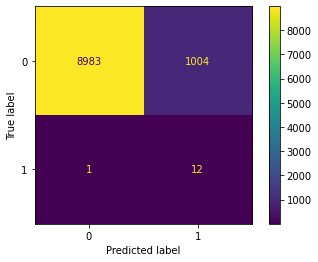

In [34]:
 grid.best_estimator_.fit(x_resampled, y_resampled)

y_predict_RandomForestClassifier =  grid.best_estimator_.predict(X_test)


plot_confusion_matrix(grid.best_estimator_, X_test, y_test) 
print(y_predict_RandomForestClassifier)

In [35]:
print(classification_report(y_test,y_predict_RandomForestClassifier))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      9987
           1       0.01      0.92      0.02        13

    accuracy                           0.90     10000
   macro avg       0.51      0.91      0.49     10000
weighted avg       1.00      0.90      0.95     10000



## XGBClassifier

In [36]:
from xgboost import XGBClassifier
XGBC = XGBClassifier(booster='gbtree')


params = {
        'XGBC__min_child_weight': [1, 5, 10,20],
        'XGBC__gamma': [0.5, 1, 1.5, 2, 5,10],
        'XGBC__max_depth': [3, 4, 5,10]
        }

grid1 = GridSearchCV(estimator = XGBC, param_grid = params, scoring = 'recall', cv=10) 

grid1.fit(x_resampled, y_resampled)



print("Mejor score (Recall): ", grid1.best_score_)   #Codigo sacado de Abolt github
print("Mejores hiperparámetros: ", grid1.best_params_)
print("Mejor modelo: ", grid1.best_estimator_)

Mejor_modelo_XGBClassifier = grid1.best_estimator_

Mejor score (Recall):  0.9586782376502002
Mejores hiperparámetros:  {'XGBC__gamma': 0.5, 'XGBC__max_depth': 3, 'XGBC__min_child_weight': 1}
Mejor modelo:  XGBClassifier(XGBC__gamma=0.5, XGBC__max_depth=3, XGBC__min_child_weight=1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[0 0 0 ... 0 0 0]


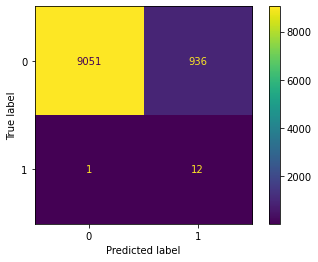

In [37]:
Mejor_modelo_XGBClassifier.fit(x_resampled, y_resampled)

y_predict_XGBClassifier =  Mejor_modelo_XGBClassifier.predict(X_test)


plot_confusion_matrix(Mejor_modelo_XGBClassifier, X_test, y_test) 
print(y_predict_XGBClassifier)

In [38]:
print(classification_report(y_test,y_predict_XGBClassifier))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      9987
           1       0.01      0.92      0.02        13

    accuracy                           0.91     10000
   macro avg       0.51      0.91      0.49     10000
weighted avg       1.00      0.91      0.95     10000



se debe incluir resultados del modelo CATBOOST